In [ ]:
import sys
sys.path.append('/workspace/')

import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset

#from data.kitti_data import KittiDataset
#from data.nuscenes_data import NuscenesDataset


from models import HRegNet, Model_V2, Model_V6
from models.utils import calc_error_np, set_seed

import argparse
import datetime
from tqdm import tqdm

#MAN Dataset
from config import Config
import dataset

from losses import transformation_loss
from metrics.calibeval import CalibEval, MultiLayerCalibEval
from dataset.data_loader import load_dataset

def parse_args(args_list=None):
    parser = argparse.ArgumentParser(description='HRegNet')

    parser.add_argument('--seed', type=int, default=1)
    parser.add_argument('--gpu', type=str, default='0')
    parser.add_argument('--root', type=str, default='')
    parser.add_argument('--npoints', type=int, default=16384)
    parser.add_argument('--epochs', type=int, default=100)
    parser.add_argument('--batch_size', type=int, default=1)
    parser.add_argument('--dataset', type=str, default='man')
    parser.add_argument('--use_fps', action='store_true')
    parser.add_argument('--data_list', type=str, default='')
    parser.add_argument('--use_weights', action='store_true')
    parser.add_argument('--pretrain_weights', type=str, default='')
    parser.add_argument('--voxel_size', type=float, default=0.3)
    parser.add_argument('--save_dir',type=str, default='')
    parser.add_argument('--augment', type=float, default=0.0)
    parser.add_argument('--freeze_detector', action='store_true')
    parser.add_argument('--freeze_feats', action='store_true')
    
    return parser.parse_args(args_list)


args = parse_args(['--use_fps', '--use_weights', '--freeze_detector', 
                   '--pretrain_weights', '/workspace/ckpt/Adaption2_ptv3/best_val_RRE.pth',
                   '--save_dir', '/workspace/results/Adaption2_ptv3/'])

# Print sample scene of the top n best and worst results from test set

In [2]:

config = Config(args=args)
config.dataset_config.mode = "C2L"
config.dataset_config.split = "test"
config.dataset_config.version = "v1.0-test"
config.dataset_config.path = "/workspace/data/truckscenes_test/"

loader = dataset.TruckScenesLoader()
man_data = dataset.TruckScenesDataset(loader(config, verbose=False), config)
sample_indices = [4447]


subset_dataset = Subset(man_data,sample_indices)
subset_loader = DataLoader(dataset=subset_dataset, batch_size=1, shuffle=False, num_workers=4)



/opt/conda/lib/python3.11/site-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


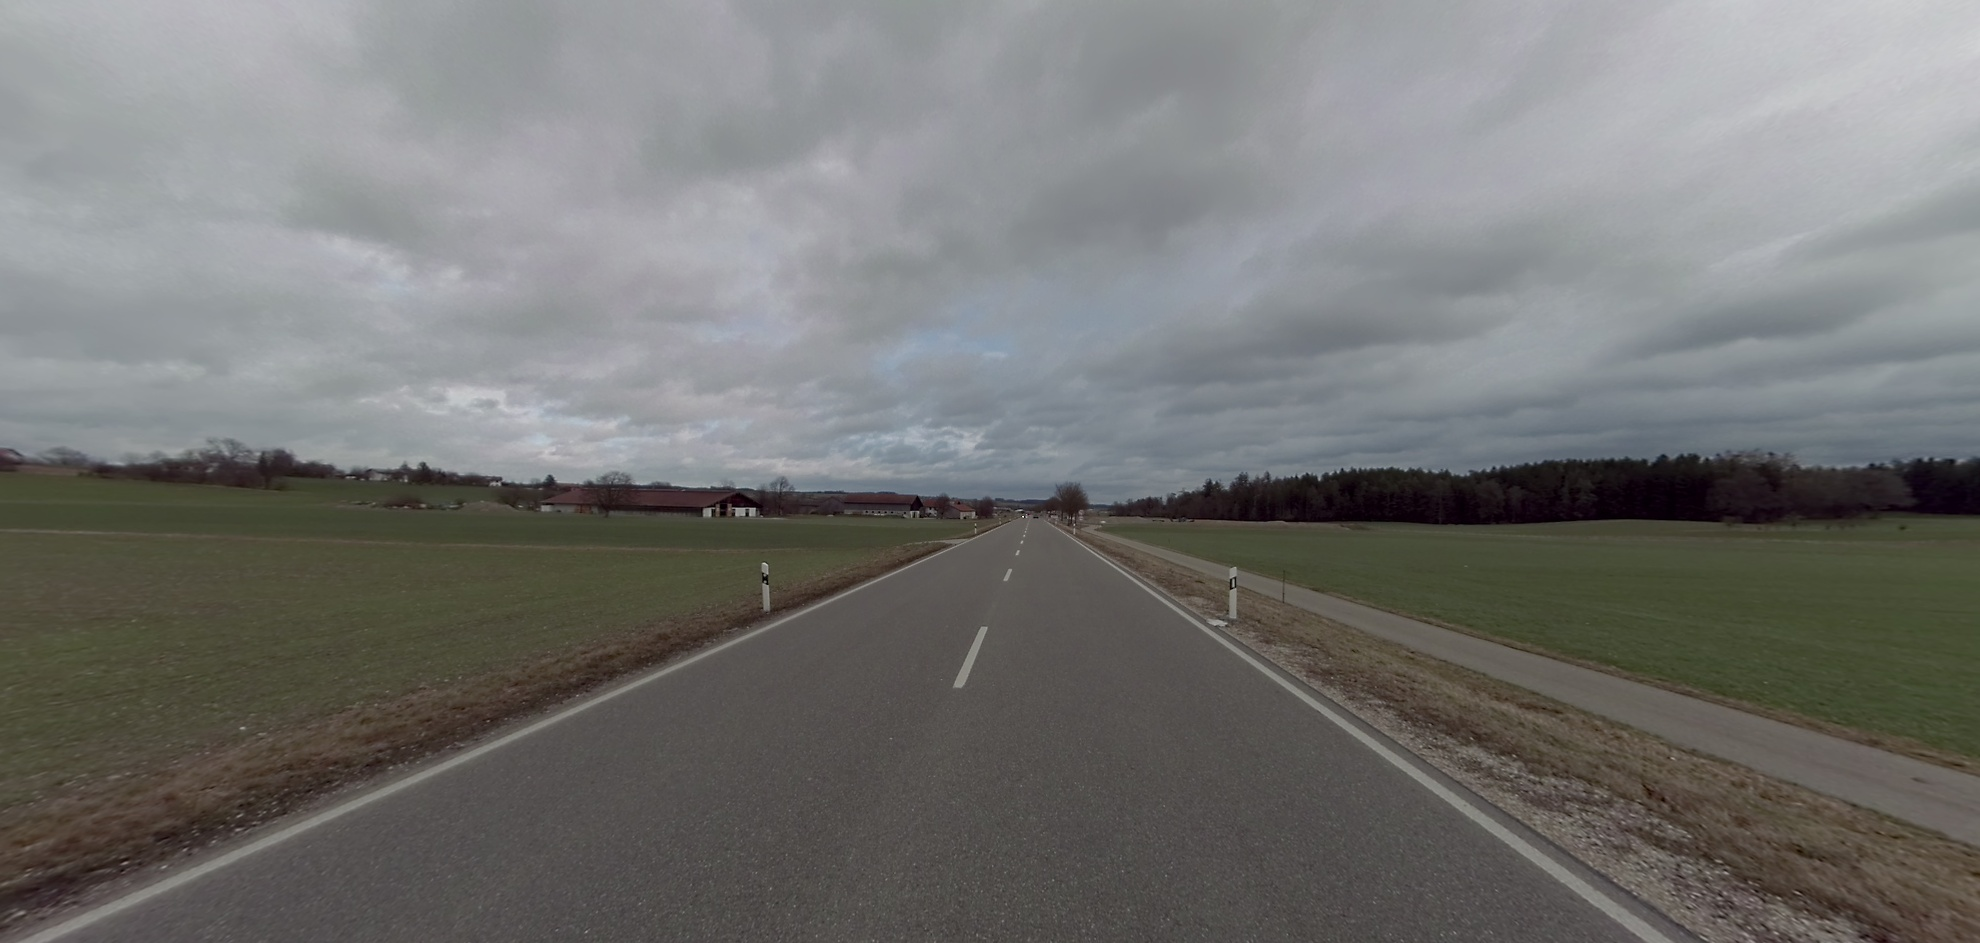

In [ ]:
from PIL import Image

def show_save_img(img,i,sample_num):
    img = img.cpu().numpy()
    img = np.transpose(img, (1,2,0))
    img=img*255
    im = Image.fromarray(img.astype('uint8'))
    im.show()
    im.save(f"worst_rot_{i}_{sample_num}.pdf")



for i, data in enumerate(subset_loader):
    img = data['image'][0]  
    original_index = sample_indices[i]
    show_save_img(img,i,original_index)
